In [1]:
import sys
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font', family = 'simhei')
mpl.rc('axes', unicode_minus = False)
%matplotlib inline

# 项目文件保存目录
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    fig.savefig(path, format=fig_extension, dpi=resolution)

# 4.1 线性回归

## 4.1.1. 标准方程

In [2]:
# 先简单试一下标准方程在拟合直线的表现
import numpy as np

X = 2 * np.random.rand(100, 1)
# 不难看出，拟合出的两个直线的参数应该接近于4和3
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure 411随机生成数据


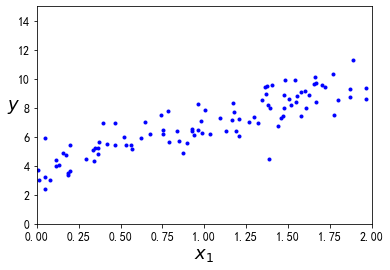

In [3]:
fig, ax = plt.subplots()

ax.scatter(X, y, c = 'b', marker = '.')
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$y$", rotation=0, fontsize=18)
ax.axis([0, 2, 0, 15])
save_fig(fig, '411随机生成数据')

In [4]:
# 开算，算之前别忘了在第一列添加一列1
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [37]:
X_b.T.dot(X_b)

array([[100.        ,  99.69100757],
       [ 99.69100757, 132.02409068]])

In [5]:
# 可以看到，最优解虽然不是4和3，但是和真实值也相当接近了，毕竟有噪音嘛，不可能直接算出4和3的
theta_best

array([[3.86420441],
       [3.01693307]])

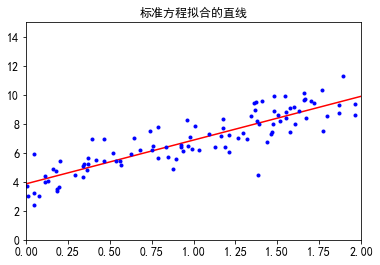

In [6]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.title('标准方程拟合的直线')
plt.show()

In [7]:
# 在sklearn中使用线性回归就非常简单了
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.86420441]), array([[3.01693307]]))

要注意的是，sklearn的`LinearRegression`类其实就是对`scipy.linalg.lstsq()` 函数的一个包装  
也就是说可以直接使用`scipy.linalg.lstsq()`函数进行最小二乘回归

In [8]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.86420441],
       [3.01693307]])

再往深了说，`np.linalg.lstsq`用的其实是$\mathbf{X}^+\mathbf{y}$方程，而不是标准方程算的  
$\mathbf{X}^+$就是$\mathbf{X}$的伪逆，准确来说是Moore-Penrose伪逆  
这么算比使用标准方程更快且更方便  
可以使用`np.linalg.pinv`来实现

In [9]:
np.linalg.pinv(X_b).dot(y)

array([[3.86420441],
       [3.01693307]])

# 4.2. 梯度下降

## 4.2.1. 批量梯度下降

In [10]:
eta = 0.1  # 学习率
# 梯度下降1000次
n_iterations = 1000
# 数据集的行数
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [11]:
# 可以发现，这与之前标准方程计算的结果一致
theta

array([[3.86420441],
       [3.01693307]])

顺便看看不同学习率下的表现

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

Saving figure gradient_descent_plot


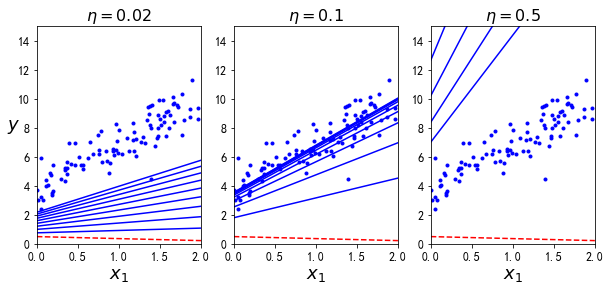

In [13]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig(plt.gcf(), "gradient_descent_plot")

## 4.2.2. 随机梯度下降

Saving figure sgd_plot


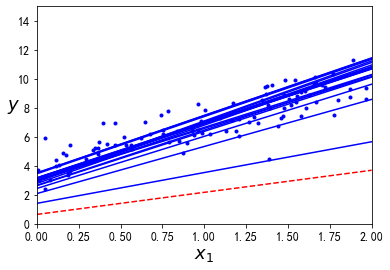

In [14]:
theta_path_sgd = []
m = len(X_b)
#np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

# 学习调度函数，来模拟退火
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
save_fig(plt.gcf(), "sgd_plot")                                 # not shown
plt.show()                                           # not shown

In [15]:
# 相比批量梯度下降，随机梯度只对整个训练集进行了50次(n_epochs)的遍历
# 效率还是挺高的
theta

array([[3.84022008],
       [2.99394334]])

In [16]:
# sklearn中的SGDRegressor自带模拟退火的功能，eta0参数就是学习率初始值
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [17]:
# 可得到截距和斜率，看着还行吼
sgd_reg.intercept_, sgd_reg.coef_

(array([3.83702173]), array([2.99737104]))

## 4.2.3. 小批量梯度下降

小批量梯度下降不是使用全部数据或仅使用一行数据计算梯度，而是使用一部分数据计算梯度  
相比随机梯度的优势是可以更稳定地梯度下降，不像随机梯度下降，迭代到最小值附近后还会来回变化  
而且小批量梯度下降可以在GPU参与的情况下算得更快  

In [18]:
# 随着梯度下降，的参数轨迹图
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

#np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    # 对数据集进行随机混洗
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [20]:
theta

array([[3.85840214],
       [3.00367419]])

In [22]:
# 记录三种随机梯度下降的参数轨迹
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

可以看到，正如之前所说，小批量梯度下降可以直抵最小值，不会像另外两种梯度下降来回踱步  
但是要注意的是，小批量梯度下降也容易取得局部最小值而出不来

Saving figure gradient_descent_paths_plot


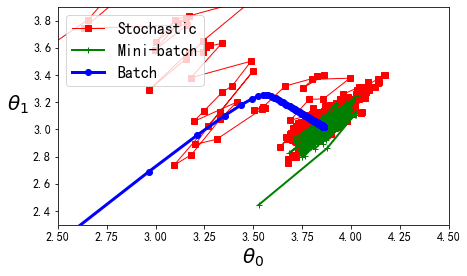

In [24]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig(plt.gcf(), "gradient_descent_paths_plot")
plt.show()

# 4.3. 多项式回归

额，这个我觉得就可以跳过了，简单记录一下就行

In [25]:
import numpy as np
import numpy.random as rnd

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

用来进行拟合操作的带噪声的抛物线数据

Saving figure quadratic_data_plot


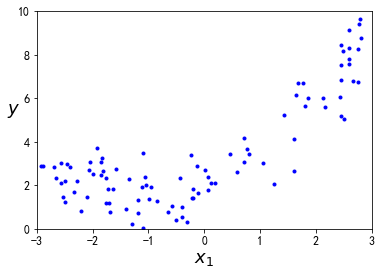

In [27]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig(plt.gcf(), "quadratic_data_plot")
plt.show()

In [28]:
# 多项式前处理
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-1.17897655])

In [29]:
# 拟合多项式特征
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.89529687]), array([[0.98950079, 0.49574229]]))

拟合后的效果

Saving figure quadratic_predictions_plot


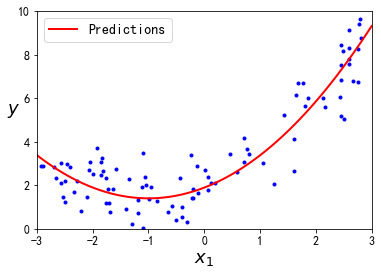

In [30]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig(plt.gcf(), "quadratic_predictions_plot")
plt.show()

不同阶数的多项式拟合

Saving figure high_degree_polynomials_plot


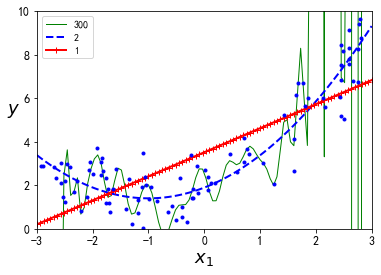

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig(plt.gcf(), "high_degree_polynomials_plot")
plt.show()

# 4.4. 学习曲线

就是随着训练集数据的增加，模型在训练集上和验证集上的误差变化  
看看代码就一目了然了  

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

这是一个线性回归的学习曲线

Saving figure underfitting_learning_curves_plot


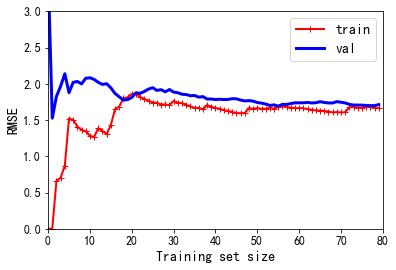

In [35]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
save_fig(plt.gcf(), "underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown

这是多项式回归在同一个数据集上的学习曲线

Saving figure learning_curves_plot


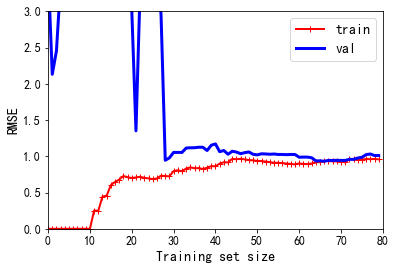

In [36]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
save_fig(plt.gcf(), "learning_curves_plot")  # not shown
plt.show()                        # not shown